# 1. Initial Setup and Reprocessing (Script 01)

### This notebook documents the reduction of an XMM-Newton observation. The primary goal is to reduce data from both the EPIC-pn detector in Timing Mode and the RGS (Reflection Grating Spectrometer).

This first script, 01_setup_and_reprocess.sh, performs the initial setup and re-calibration for both instrument sets. It runs:

    cifbuild and odfingest: To create the necessary ccf.cif and *SUM.SAS summary files.

    epproc: To re-process the raw PN Timing Mode data.

    rgsproc: To re-process the raw RGS data.

The products are stored in products/[OBSID].

**Important Note**: After this step, the following scripts (02, 03, 04, 05) will focus exclusively on the PN Timing Mode data (filtering, pile-up, and spectral extraction). RGS-specific scripts will be handled separately and named accordingly (e.g., 02b_RGS_reduction.sh).

This script assumes Heasoft and SAS have been initialized.

The script requires the environment variables:

    $PROJECT_ROOT: The absolute path to the project's root directory.

    $OBSID: The 10-digit observation ID.

    $SAS_CCFPATH: The absolute path to the calibration files.


In [1]:
import os

from setuptools.command.rotate import rotate

os.environ['PROJECT_ROOT'] = '/media/kyle/kyle_phd/Swift-j1858.6-0814/'
os.environ['OBSID'] = '0865600201'

# Get Project Root and ObsID from the environment (set in Cell 2)
project_root = os.environ.get('PROJECT_ROOT')
obsid = os.environ.get('OBSID')


Because epproc and rgsproc produce hundreds of lines of output, I will not print this to the notebook. Instead, I am redirecting all standard output (>) and standard error (2>&1) to a single log file: logs/01_setup_and_reprocess.log.


In [6]:
!mkdir -p logs

!../scripts/01_setup_and_reprocess.sh > logs/01_setup_and_reprocess.log 2>&1
!tail -n 5 logs/01_setup_and_reprocess.log


Setup files (ccf.cif, 3717_0865600201_SCX00000SUM.SAS) are in /media/kyle/kyle_phd/Swift-j1858.6-0814//data/0865600201
Log files are in /media/kyle/kyle_phd/Swift-j1858.6-0814//products/0865600201/pn/epproc.log and /media/kyle/kyle_phd/Swift-j1858.6-0814//products/0865600201/rgs/rgsproc.log
Check log files for any errors or warnings.
You can now proceed with data reduction.
--------------------------------------------------



# **2. Background Flare Filtering (Script 02)**

### The next step is to filter the reprocessed event file (\*EPN\*Evts.ds) to remove periods of high particle background (flares).

#### This script, 02_filter_background.sh, is designed for a two-step workflow:

**First Run**: We run it with the default APPLY_FILTER="no". This will only generate diagnostic lightcurves (pn_bkg_lc.jpg and pn_src_lc.jpg).

**Inspect**: We will load and view the background plot (pn_bkg_lc.jpg) directly in this notebook.

**Edit & Re-run**: Based on the plot, we will manually edit the script to set APPLY_FILTER="yes" and a RATE_THRESHOLD. We then re-run the script to create the final pn_clean.evt file.

### Step 2a: First Run (Generate Plots)

I will now run the script for the first time.

We use the expression "#XMMEA_EP && (PI>10000&&PI<12000) && (PATTERN<=0)" for the EPIC-PN to produce the background light curve only including events between 10 and 12 keV and single event patterns. The reason for this is to avoid hot pixels being miss-identified as very high energy events.

In [9]:
# Run the script. The default setting APPLY_FILTER="no" is used.
!../scripts/02_filter_high_background.sh > logs/02_filter_run1_plots.log 2>&1
# Check the log file for the success message
!grep "Plots created in" logs/02_filter_run1_plots.log

Plots created in /media/kyle/kyle_phd/Swift-j1858.6-0814//products/0865600201/pn. Please inspect background lightcurve: /media/kyle/kyle_phd/Swift-j1858.6-0814//products/0865600201/pn/pn_bkg_lc.jpg


### Step 2b: Inspect Background Plot

The script ran successfully and created the plots. Now, I will load and display the background lightcurve to decide on a filtering threshold.

If the image shows strong flaring, _**dsplot**_ or **_fv_** can be used to inspect the background lightcurve file (pn_bkg_lc.fits) in more detail.

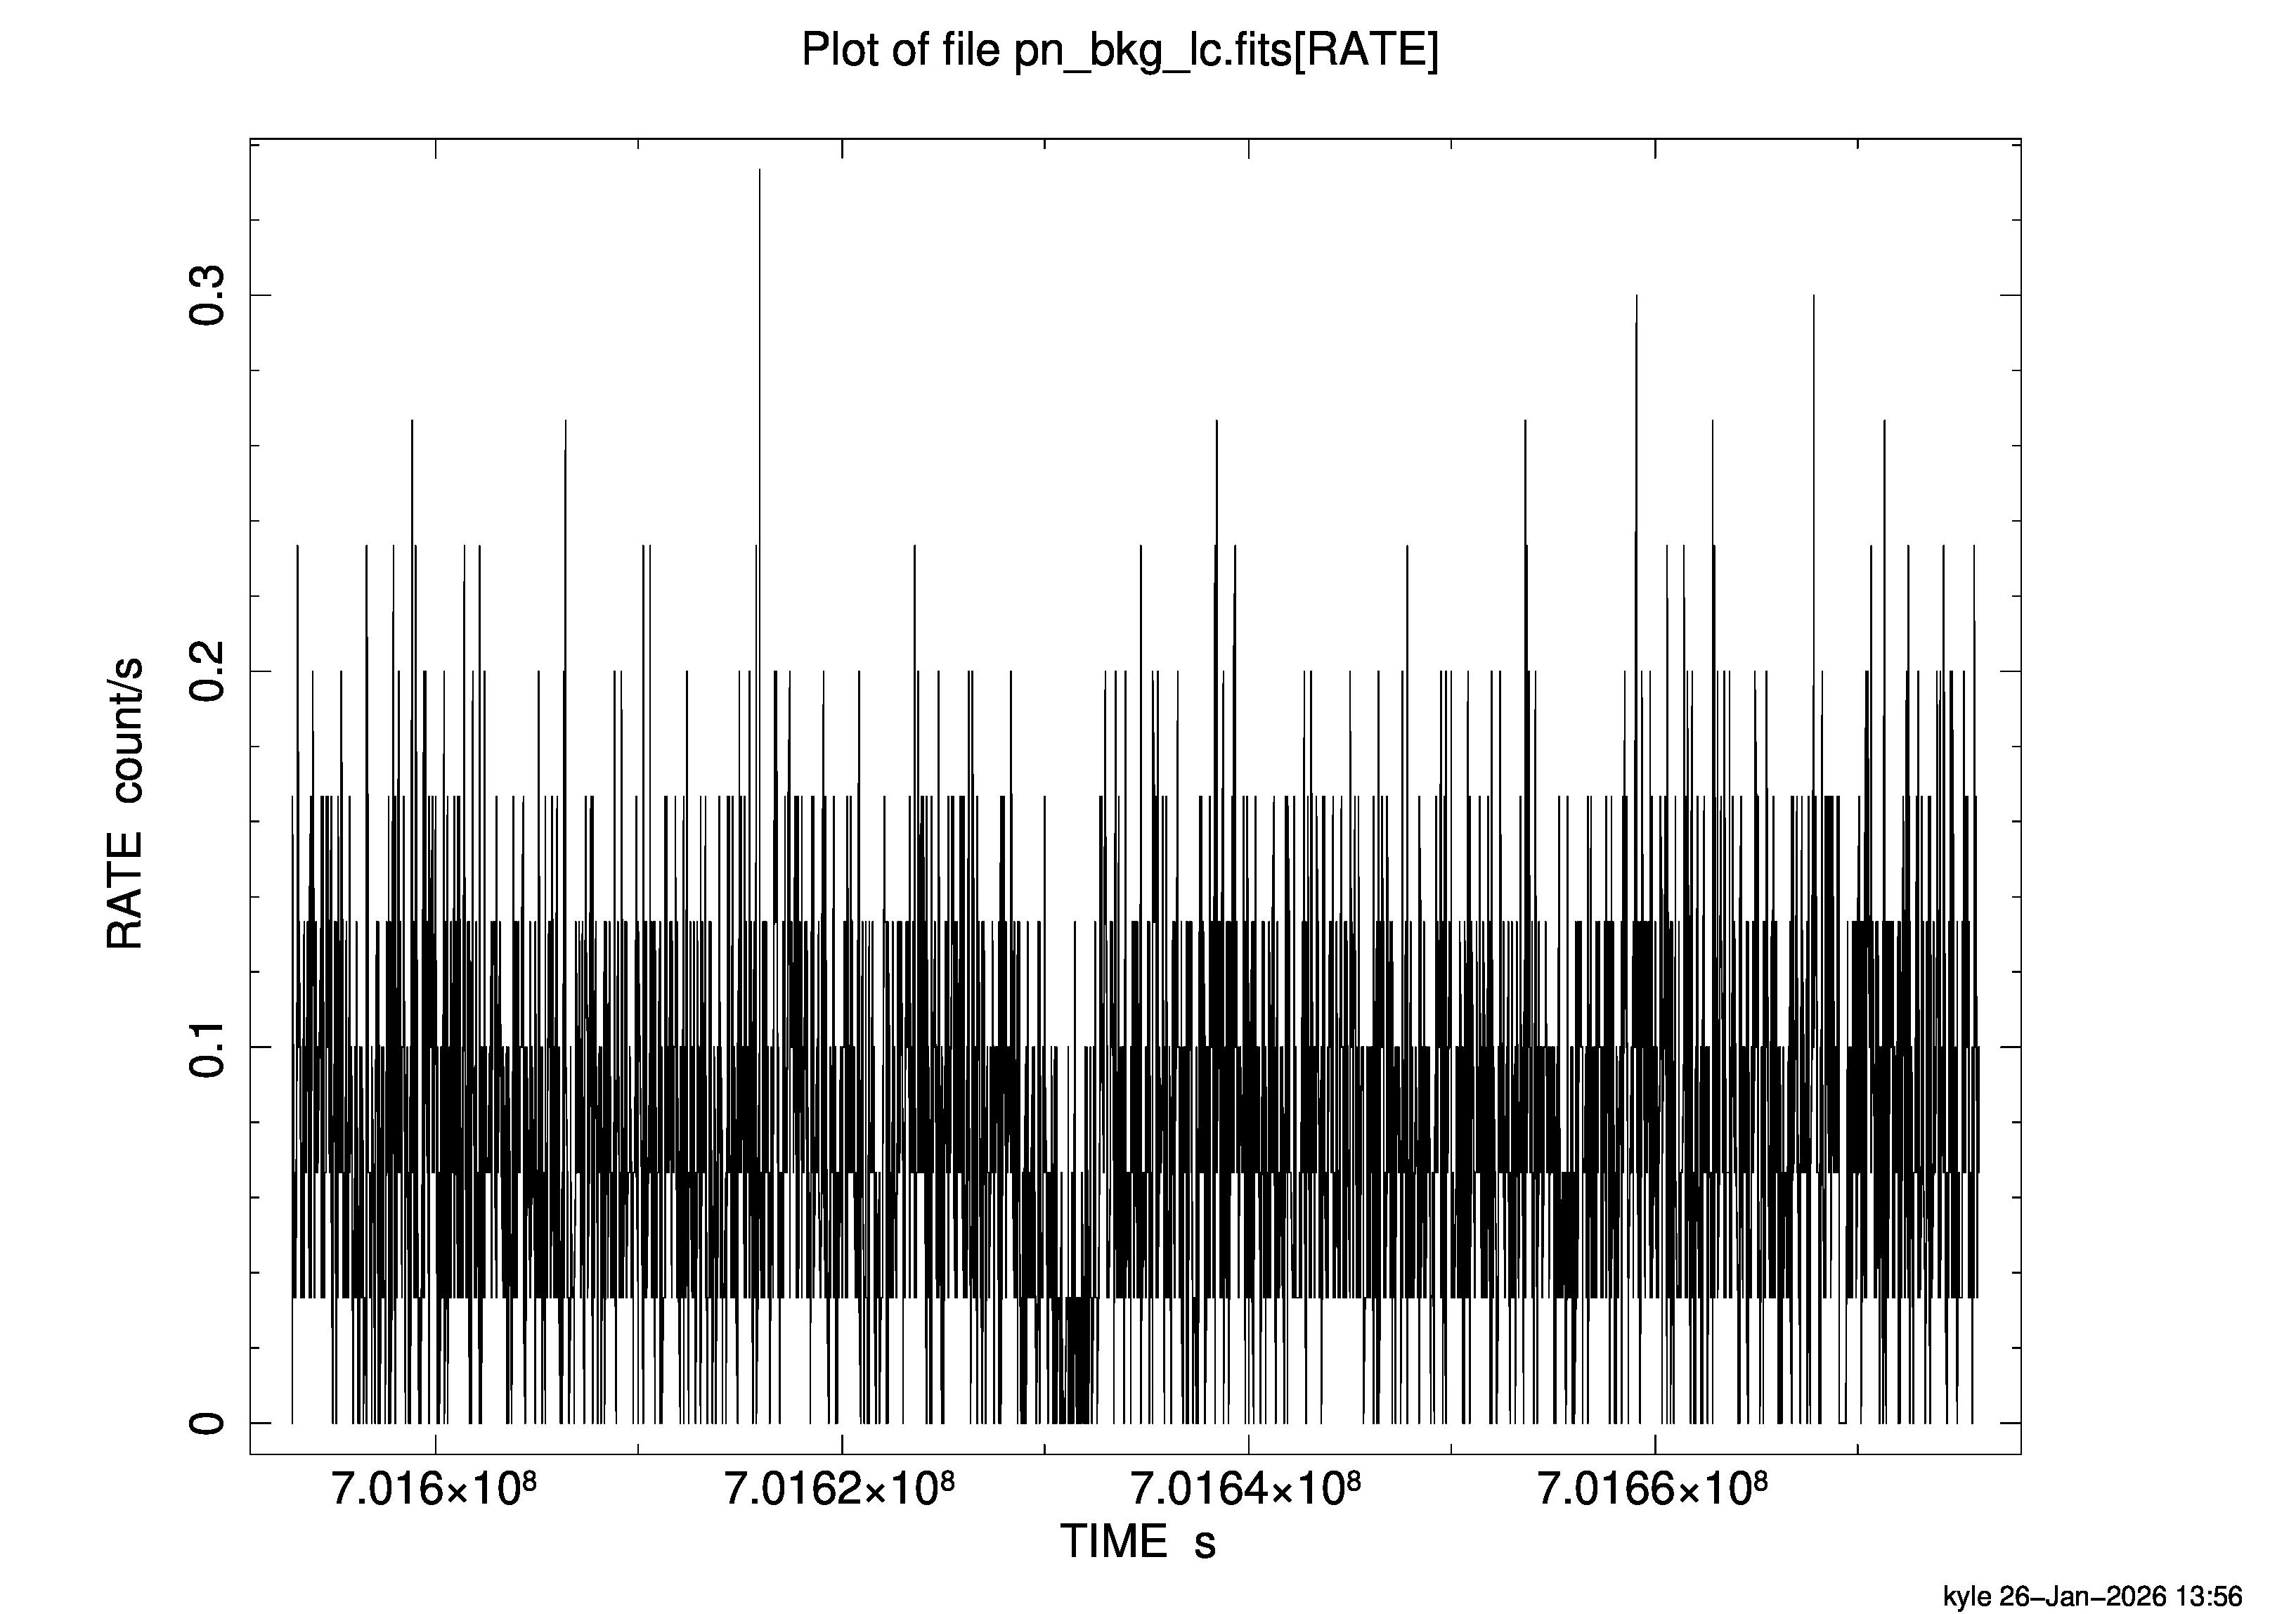

In [10]:
# Get ObsID from the environment variable to build the plot path
from PIL import Image
from IPython.display import Image as IPyImage, display
from io import BytesIO
import os

pn_dir = f"{project_root}/products/{obsid}/pn/"
bkg_plot_path = f"{pn_dir}/pn_bkg_lc.jpg"
# Load and display the background lightcurve plot
if os.path.exists(bkg_plot_path):
    img = Image.open(bkg_plot_path)
    rotated = img.rotate(-90, expand=True)  # rotate 90 degrees anticlockwise
    buf = BytesIO()
    rotated.save(buf, format='JPEG')
    buf.seek(0)
    display(IPyImage(data=buf.getvalue(), width=800))
else:
    print(f"ERROR: Plot not found at {bkg_plot_path}")
    print("Please check the log: logs/02_filter_run1_plots.log")

### Step 2c: Decision and Script Edit

Based on the displayed background lightcurve, there is no strong particle flaring. Therefore, I will not rerun the script with filtering enabled. The default event file (pn_clean.evt) with expression "#XMMEA_EP && (PI>200)" will be used for further analysis.

Should there have been significant flaring, I would edit the script to set APPLY_FILTER="yes" and specify a RATE_THRESHOLD based on the plot, then rerun the script to generate a filtered event file.